In [39]:
!pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable


In [40]:
!pip install scikit-image


Defaulting to user installation because normal site-packages is not writeable


In [41]:
!pip install tqdm


Defaulting to user installation because normal site-packages is not writeable


In [42]:
!pip install ipywidgets


Defaulting to user installation because normal site-packages is not writeable


In [43]:
# Imports
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import local_binary_pattern
from tqdm import tqdm
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import io


In [44]:
# Constants
DATA_DIR = "./images"
CSV_PATH = "./train.csv"
IMAGE_SIZE = (128, 128)
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS

# Load CSV and encode labels
df = pd.read_csv(CSV_PATH)
df['label'] = df[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)
df['path'] = df['image_id'].apply(lambda x: os.path.join(DATA_DIR, f"{x}.jpg"))

# Label encoding
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label_enc'] = df['label'].map(label_map)


In [45]:
# Feature Extraction Function
def extract_features(img):
    img = cv2.resize(img, IMAGE_SIZE)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [32], [0, 256]).flatten()
        hist_features.extend(hist)

    lbp = local_binary_pattern(img_gray, LBP_POINTS, LBP_RADIUS, method="uniform")
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), range=(0, LBP_POINTS + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    features = np.concatenate([hist_features, lbp_hist])
    return features


In [46]:
# Extract features
features = []
labels = []

print("Extracting features...")
for i, row in tqdm(df.iterrows(), total=len(df)):
    img = cv2.imread(row['path'])
    if img is not None:
        feat = extract_features(img)
        features.append(feat)
        labels.append(row['label_enc'])
    else:
        print(f"Warning: Could not read {row['path']}")

X = np.array(features)
y = np.array(labels)

# Scale and split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


Extracting features...


100%|██████████████████████████████████████████████████████████████████████████████| 1821/1821 [00:23<00:00, 76.55it/s]


In [47]:
# Evaluation function
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, preds, target_names=label_map.keys()))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



SVM Classification Report:
                   precision    recall  f1-score   support

             scab       0.57      0.65      0.60       119
multiple_diseases       0.29      0.11      0.16        18
          healthy       0.57      0.58      0.58       103
             rust       0.59      0.55      0.57       125

         accuracy                           0.57       365
        macro avg       0.50      0.47      0.48       365
     weighted avg       0.56      0.57      0.56       365



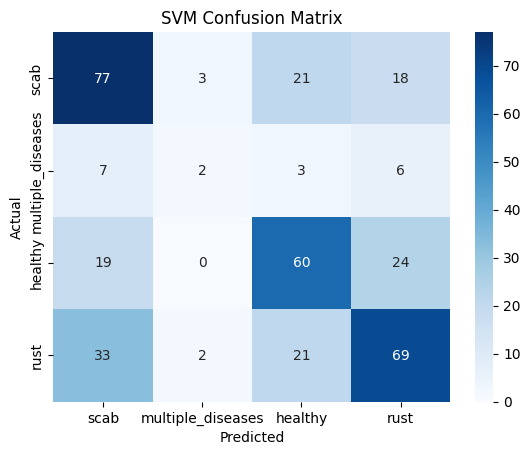


Random Forest Classification Report:
                   precision    recall  f1-score   support

             scab       0.60      0.73      0.66       119
multiple_diseases       0.00      0.00      0.00        18
          healthy       0.63      0.56      0.59       103
             rust       0.66      0.68      0.67       125

         accuracy                           0.63       365
        macro avg       0.47      0.49      0.48       365
     weighted avg       0.60      0.63      0.61       365



C:\Users\shrey\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\shrey\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\shrey\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

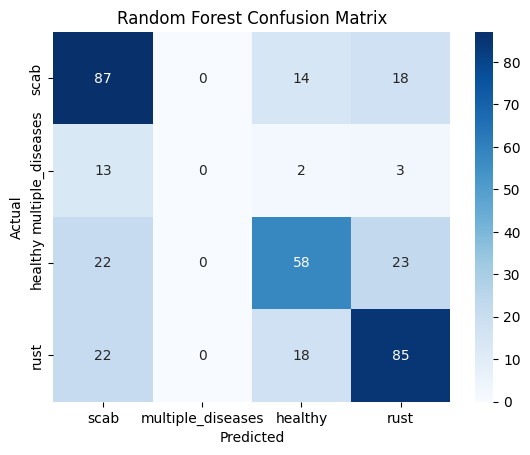


Gradient Boosting Classification Report:
                   precision    recall  f1-score   support

             scab       0.62      0.66      0.64       119
multiple_diseases       0.00      0.00      0.00        18
          healthy       0.60      0.60      0.60       103
             rust       0.62      0.66      0.64       125

         accuracy                           0.61       365
        macro avg       0.46      0.48      0.47       365
     weighted avg       0.58      0.61      0.60       365



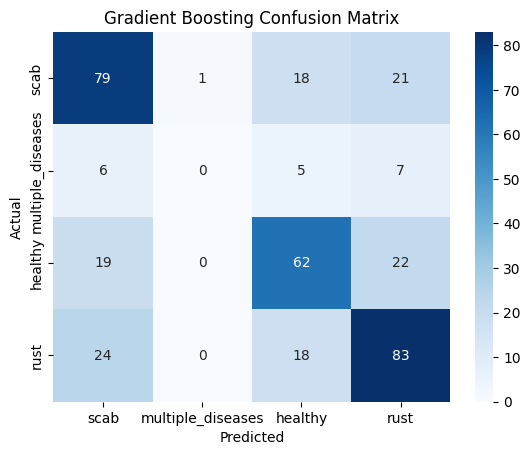

In [48]:
# Train models
svm = SVC(kernel='rbf', C=10, gamma=0.01)
evaluate_model(svm, "SVM")

rf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf, "Random Forest")

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model(gb, "Gradient Boosting")


In [53]:
from IPython.display import clear_output

def predict_image_notebook(model):
    uploader = widgets.FileUpload(accept='image/*', multiple=False)
    output = widgets.Output()

    def on_upload_change(change):
        output.clear_output()
        with output:
            if uploader.value:
                file_info = uploader.value[0]  # it's a tuple or list of dicts
                image_data = file_info['content']
                try:
                    img = Image.open(io.BytesIO(image_data)).convert("RGB")
                    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
                    img_cv = cv2.resize(img_cv, IMAGE_SIZE)
                    features = extract_features(img_cv)
                    features = scaler.transform([features])
                    pred = model.predict(features)[0]

                    label_inverse_map = {v: k for k, v in label_map.items()}
                    prediction = label_inverse_map[pred]

                    print(f"\n Predicted class: **{prediction}**")
                    plt.imshow(img)
                    plt.title(f"Prediction: {prediction}")
                    plt.axis("off")
                    plt.show()
                except Exception as e:
                    print(f" Error: {e}")
            else:
                print(" Please upload an image.")

    uploader.observe(on_upload_change, names='value')
    display(widgets.VBox([uploader, output]))


In [54]:
predict_image_notebook(gb)
